# Week 6: Decision Tree 


Decision Tree is a basic but common and useful classification algorithm. 
It is also the basis of slightly more advanced classification techniques such as Random Forest and (some implementations of) Gradient Boosting. 


Ref: [sklearn decision tree classifier.][1] 


  [1]: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## 1- Data Preparation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.model_selection import train_test_split
import graphviz 
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import Imputer
#from sklearn.metrics import confusion_matrix
#from subprocess import check_output
from sklearn import tree
#from IPython.display import Image as PImage
#from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
#import re
import matplotlib.pyplot as plt



Read the data

In [2]:
# Read CSV file into DataFrame
train_df = pd.read_table("data/Titanic.csv", sep=',')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing Value Replacement

In [3]:
print('Missing values before replacement--------- ')
print(train_df.isnull().mean())

train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)

train_data.drop('Cabin', axis=1, inplace=True)

maxemb=train_df['Embarked'].value_counts().index[0]
train_data["Embarked"].fillna(maxemb, inplace=True)

print('Missing values after replacement----')
print(train_data.isnull().mean())

Missing values before replacement--------- 
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
Missing values after replacement----
PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64


In [4]:
## Create categorical variable for traveling alone
train_data['Isalone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])

training.drop(columns=['Name', 'Sex_female', 'PassengerId', 'Ticket'], inplace=True)

final_train = training
final_train.head()


# Add extra column for age under 16
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)


    
cols = ["Age","Fare","Isalone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


#Decision Tree Classifier Hyper-Parameters



## 2- Criterion 

From Sklearn documentation:

**criterion : string, optional (default=”gini”)
The function to measure the quality of a split. 
Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.**


1. Train two DecisionTreeClassifier with criterion = "entropy" and "gini"
1. Compare the scores for both


In [5]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(X_train,y_train)
print('Accuracy using the defualt gini impurity criterion...',clf.score(X_test,y_test))

clf = DecisionTreeClassifier(max_depth = 3, criterion = "entropy")
clf.fit(X_train,y_train)
print('Accuracy using the entropy criterion...',clf.score(X_test,y_test))

Accuracy using the defualt gini impurity criterion... 0.7762711864406779
Accuracy using the entropy criterion... 0.7762711864406779


## 3- Splitter

From Sklearn documentation:

**The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.**

Usually, the decision tree chooses to split each node in the optimal point (based on the gini impurity or entropy information gain). However, it would be faster, and possibly not much worse, to use a random split.


**Train a DecisionTreeClassifier on X_train,y_train with max_depth = 3 for,**  
1. splitter = 'best'
1. splitter = 'random'

**Note:** Compare running time (use [time.time()](https://stackoverflow.com/questions/13890935/does-pythons-time-time-return-the-local-or-utc-timestamp)) and accuracy (use clf.score(X_test,y_test))

In [22]:
t = time.time()
clf = DecisionTreeClassifier(max_depth = 5, splitter = 'best')
clf.fit(X_train,y_train)
print('Best Split running time...',time.time() - t)
print('Best Split accuracy...',clf.score(X_test,y_test))

t = time.time()
clf = DecisionTreeClassifier(max_depth = 5, splitter = 'random')
clf.fit(X_train,y_train)
print('Random Split running time...',time.time() - t)
print('Random Split accuracy...',clf.score(X_test,y_test))

Best Split running time... 0.0029408931732177734
Best Split accuracy... 0.7898305084745763
Random Split running time... 0.002993345260620117
Random Split accuracy... 0.7966101694915254


### Plot the tree with Graphviz and for both,

1. splitter = 'best' 
1. splitter = 'random'

Steps: 1- Train DecisionTreeClassifier 2- Use tree.export_graphviz [(example from sklearn here)](https://scikit-learn.org/stable/modules/tree.html#classification)

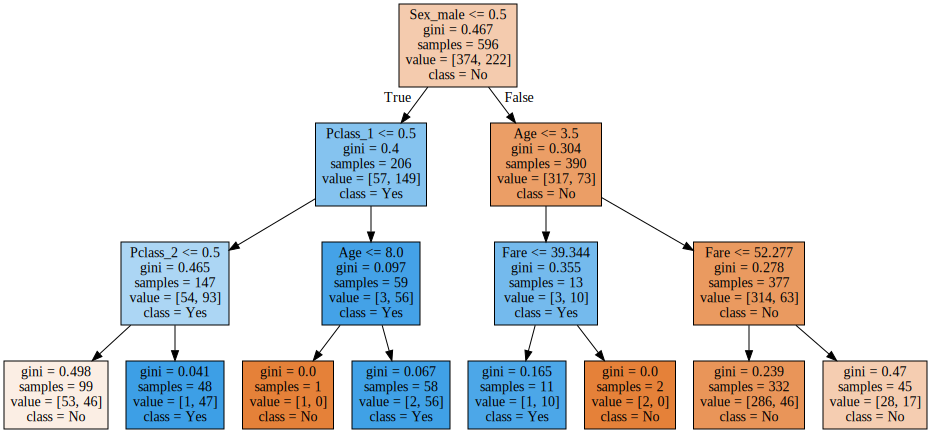

In [7]:
clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(X_train,y_train)


    
dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 



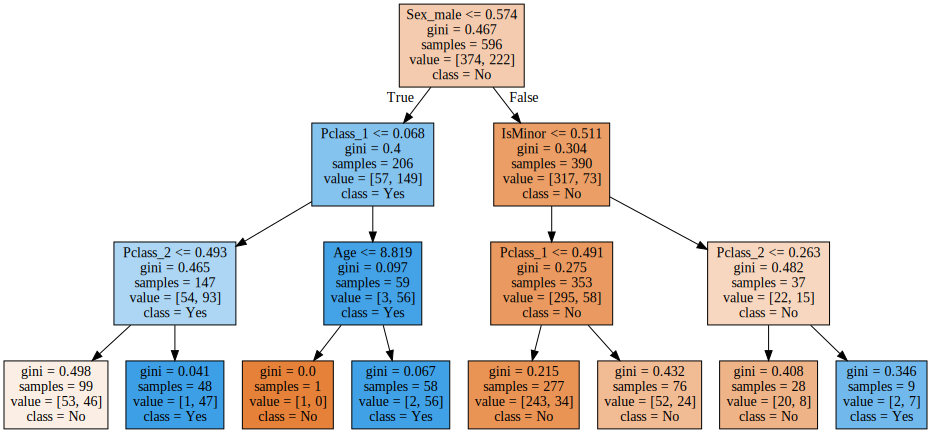

In [8]:
clf = DecisionTreeClassifier(max_depth = 3, splitter='random')
clf.fit(X_train,y_train)


    
dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 



We can see that the random splitter chooses rather odd splitting values (for instance, split on a strange number for the sex where 1 is female and 0 is male doesn't seem to make much sense logically). Since the split is random, this means that the selected feature can be different and the structure of the trees would be different.




## 4- Max Features

Using the max_feature knob, we can limit the number of features to be considered. The algorithm would randomly choose the number of features (based on the limit) and only then pick the best partition from the new group.

 - The number of features to consider when looking for the best split:
    2. If int, then consider max_features features at each split.
    3. If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
    4. If “auto”, then max_features=sqrt(n_features).
    5. If “sqrt”, then max_features=sqrt(n_features).
    6. If “log2”, then max_features=log2(n_features).
    7. If None, then max_features=n_features.
    8. Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.




This is done in order to increase the stability of the tree and reduce variance and over-fitting.

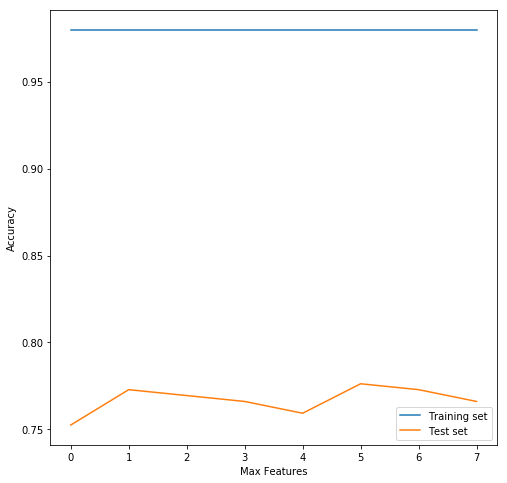

In [28]:
columns=X_train.columns
test_score = []
train_score = []
max_features = range(len(columns)-1)

for feat in max_features:
    clf = DecisionTreeClassifier( max_features = feat + 1)
    clf.fit(X_train,y_train)
    train_score.append(clf.score(X_train,y_train))
    test_score.append(clf.score(X_test,y_test))

plt.figure(figsize = (8,8))
plt.plot(max_features,train_score)
plt.plot(max_features, test_score)
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

**Observations:**
1. Training score is constant and close to 100%, while the validation score is much lower (sign of over-fitting). 
1. This is due to the fact that we haven't limited the tree depth. therefore, it keeps creating new nodes until all the leaves are "pure". 

**Repeat the above graph with a limit on the tree depth max_depth = 3**


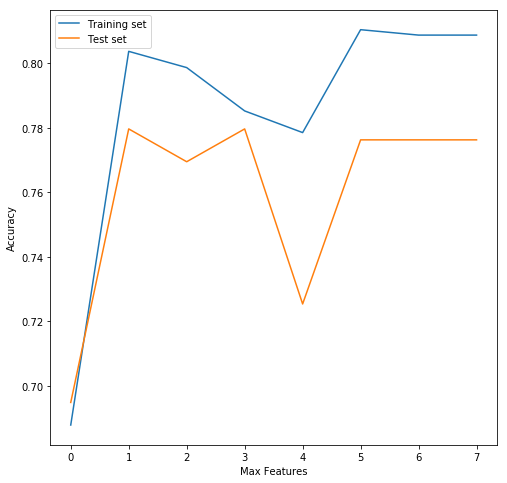

In [29]:
test_score = []
train_score = []
max_features = range(len(columns)-1)

for feat in max_features:
    clf = DecisionTreeClassifier(max_features = feat + 1, max_depth = 3)
    clf.fit(X_train,y_train)
    train_score.append(clf.score(X_train,y_train))
    test_score.append(clf.score(X_test,y_test))
    
plt.figure(figsize = (8,8))   
plt.plot(max_features,train_score)
plt.plot(max_features, test_score)
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

When the number of features is too low the tree is under fitting. 

## 5- Max Depth

**The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.**

I find this parameter to be the most useful in reducing over-fitting. 

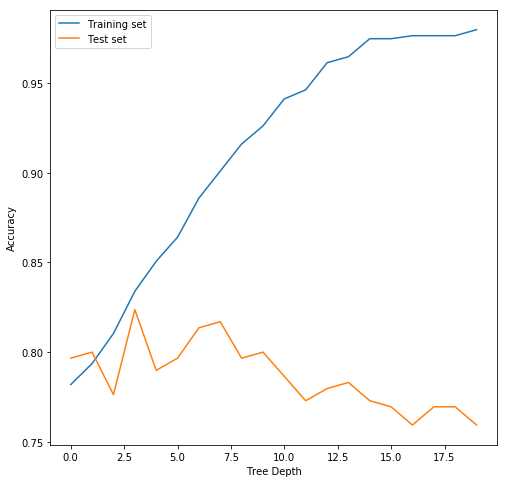

In [30]:
test_score = []
train_score = []
for depth in range(20):
    clf = DecisionTreeClassifier(max_depth = depth + 1)
    clf.fit(X_train,y_train)
    train_score.append(clf.score(X_train,y_train))
    test_score.append(clf.score(X_test,y_test))

plt.figure(figsize = (8,8))
plt.plot(range(20),train_score)
plt.plot(range(20), test_score)
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

The deeper the tree is, the better it fits the training data. however, if it is deep enough, if fails to generalize and starts to over-fit. more complex paths are created and the number of samples in every split is getting smaller and therefor less statistically meaningful. 

**Visualize a shallow and a deep tree with max_depth=3 and 6:**

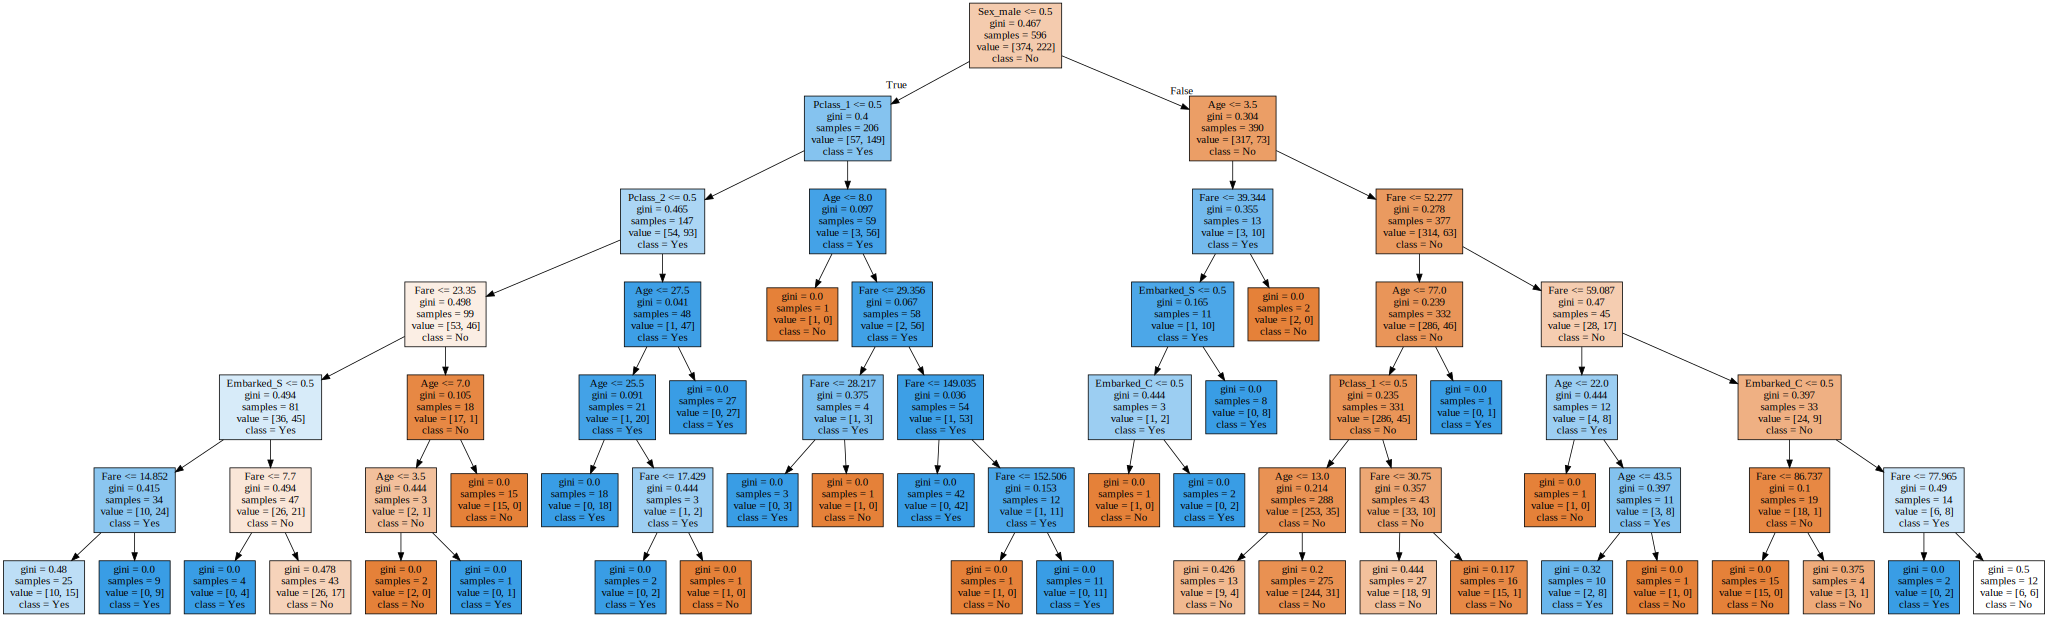

In [12]:
clf = DecisionTreeClassifier(max_depth = 6)
clf.fit(X_train,y_train)


    
dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 



When the tree is deep, we get nodes and leaves with a very small number of samples, which are therefore not very informative. we can also see that in the shallower tree, though not as common. 

The shallow tree is more simple and straight forward: 

 - if you're a man, you are unlikely to survive unless you're young.
 - If you're a woman, you're likely to survive unless you paid a low
   fare and bought a low-class ticket.

The deeper tree has more convulated rules: if you're younger than this, but older than this, but younger than this. etc.



## 6- Min Sample Split

**The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a percentage and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.**

This limitation is similar to the tree depth, but instead of constraining the depth, it constrains the number of samples per split. we have seen in the previous example how a low number of samples in a split may lead to over-fitting

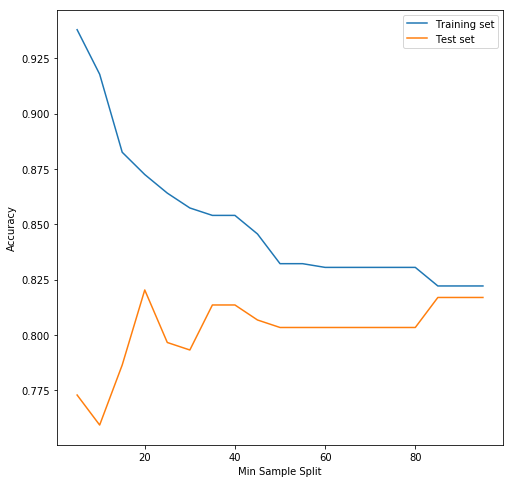

In [13]:
test_score = []
train_score = []
min_sample_split = np.arange(5,100,5)
for split in min_sample_split:
    clf = DecisionTreeClassifier(min_samples_split = split)
    clf.fit(X_train,y_train)
    train_score.append(clf.score(X_train,y_train))
    test_score.append(clf.score(X_test,y_test))
    
plt.figure(figsize = (8,8))   
plt.plot(min_sample_split,train_score)
plt.plot(min_sample_split, test_score)
plt.xlabel('Min Sample Split')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

**Observation:** Increasing "Min Sample Split" limits the growth of tree (limits overfitting)

**Visualize a shallow and a deep tree with min_samples_split = 5 and 80**

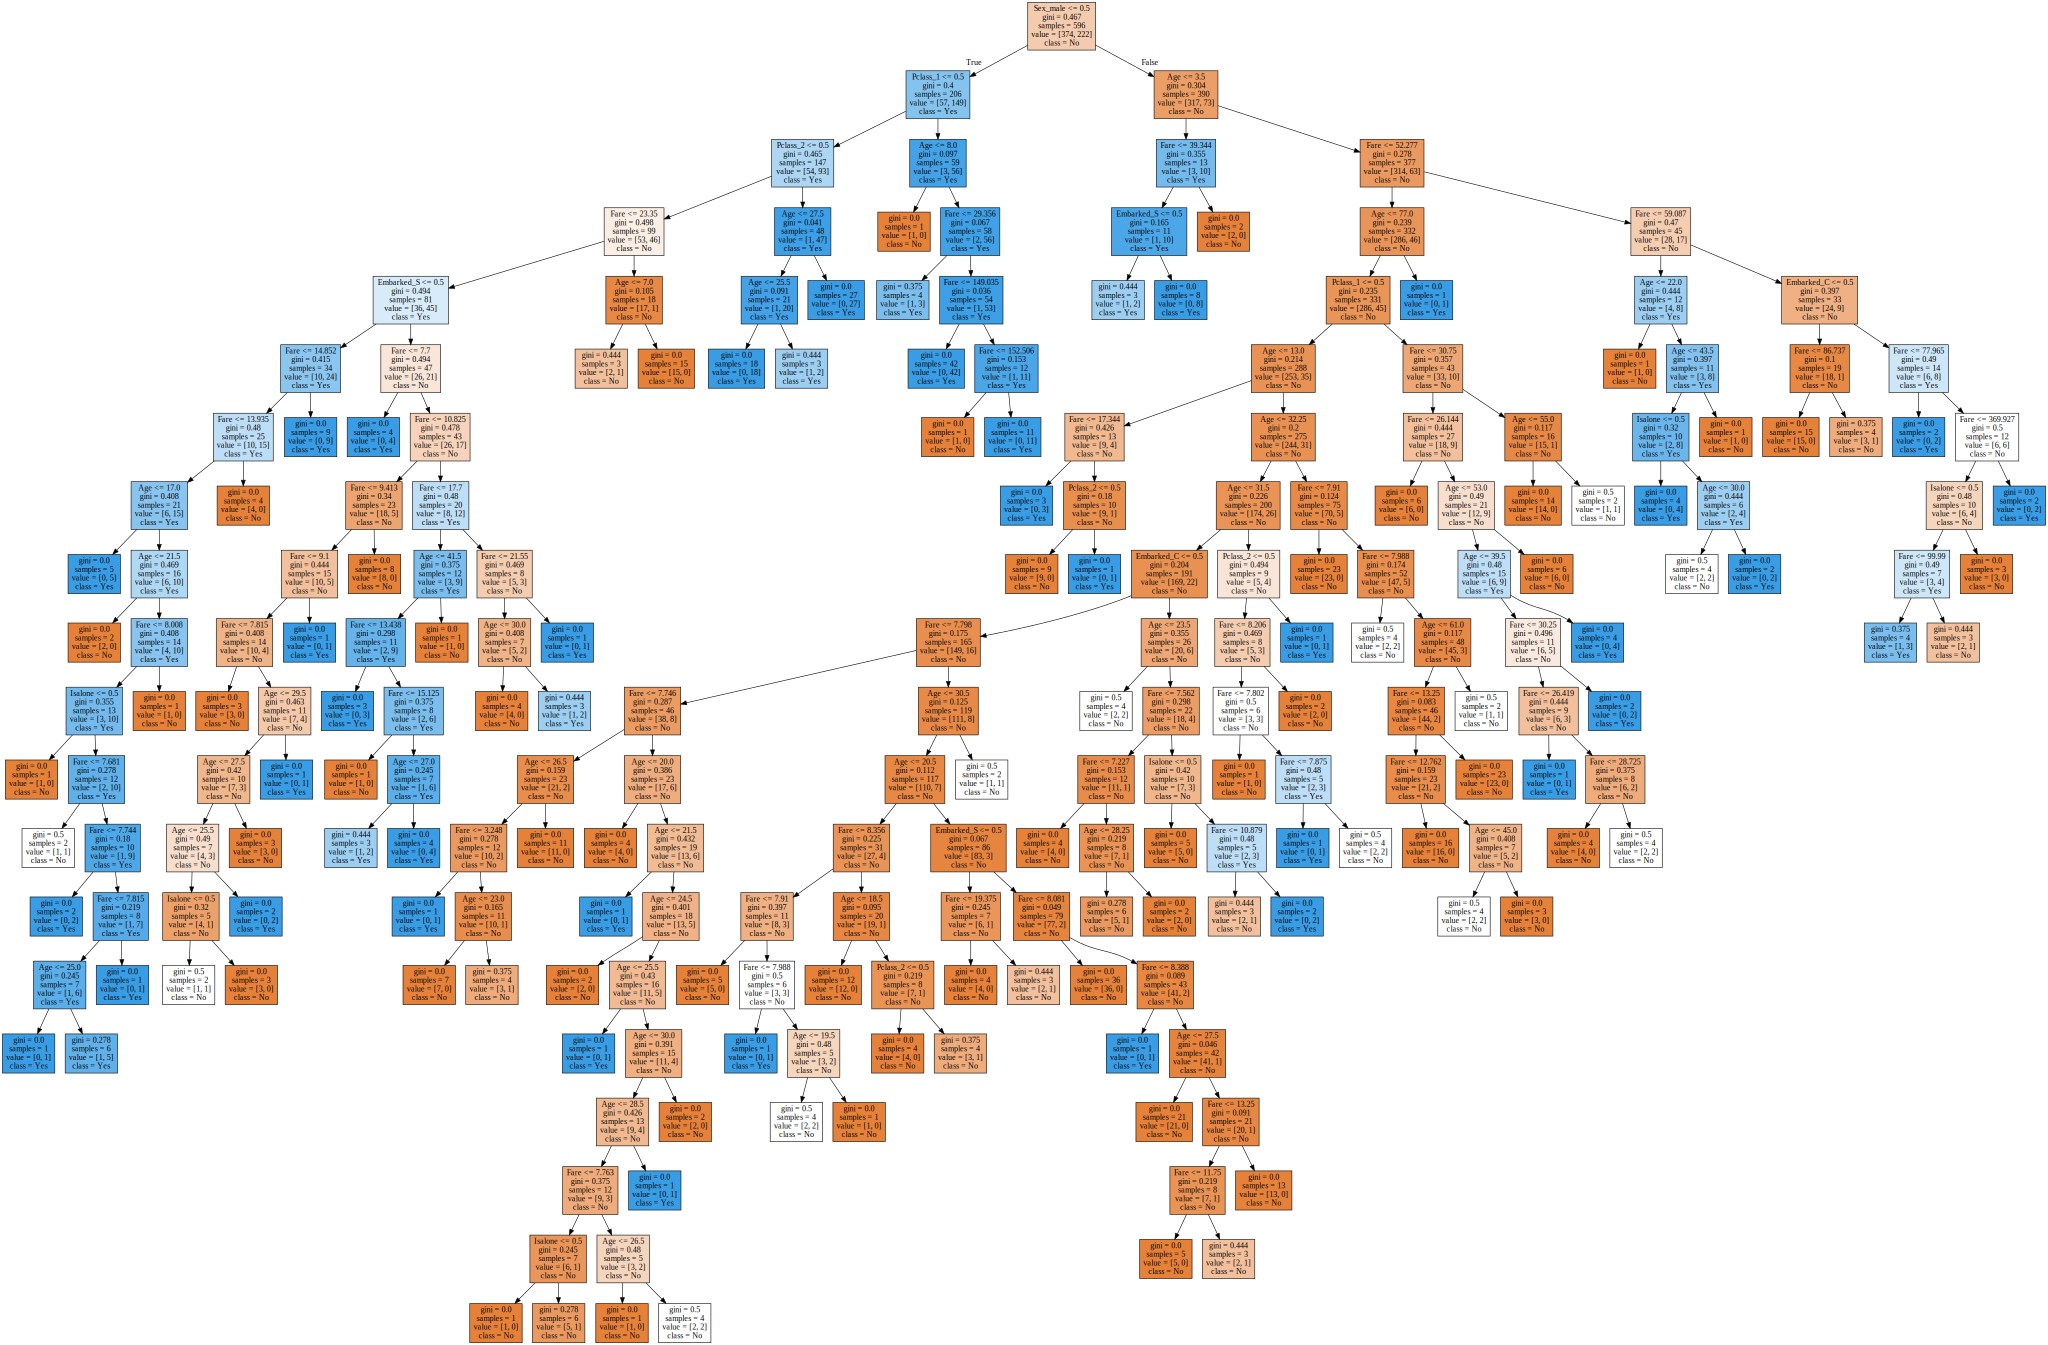

In [14]:
clf = DecisionTreeClassifier(min_samples_split = 5)
clf.fit(X_train,y_train)

dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 


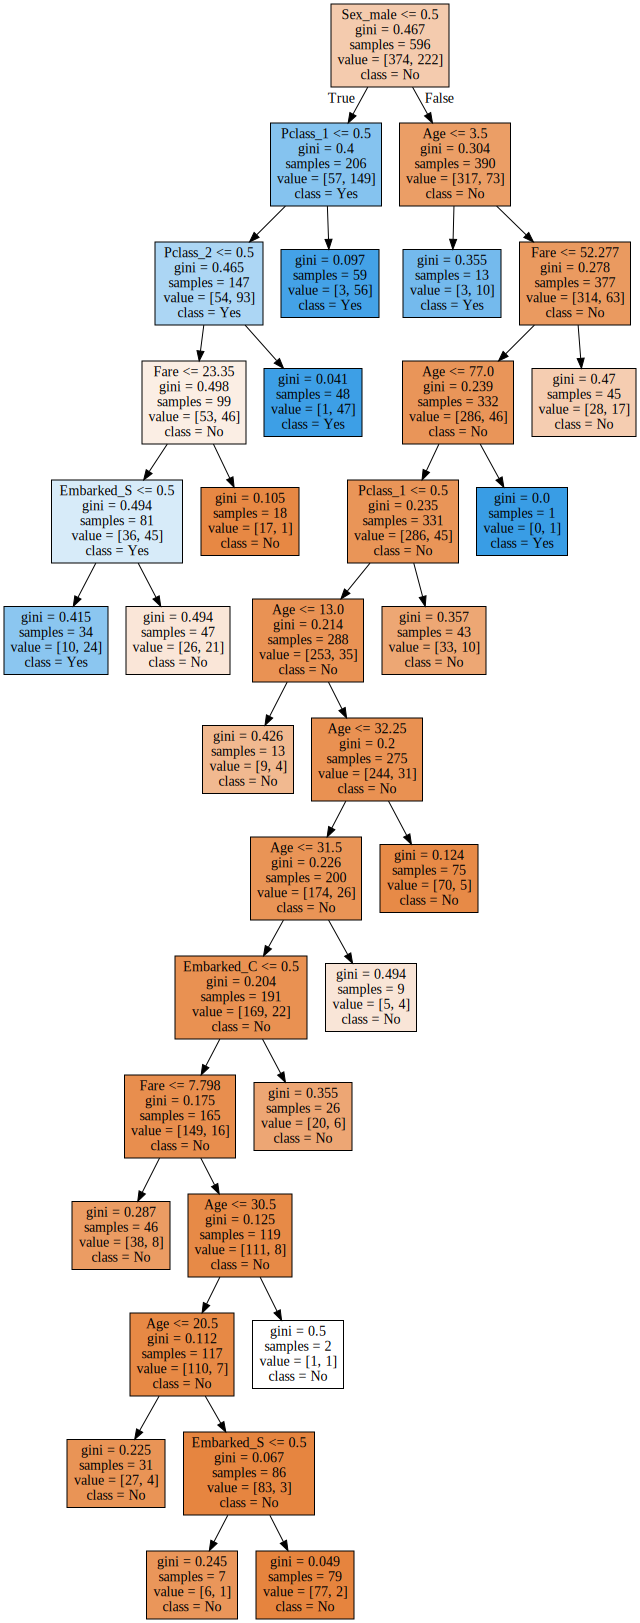

In [15]:
clf = DecisionTreeClassifier(min_samples_split = 80)
clf.fit(X_train,y_train)

dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 


## 7- Min sample leaf

**The minimum number of samples required to be at a leaf node.**

This is similar to the previous parameter, but concerns with the leaf nodes. If this limit is too tight (large numbers in min_samples_leaf), our model would under-fit.


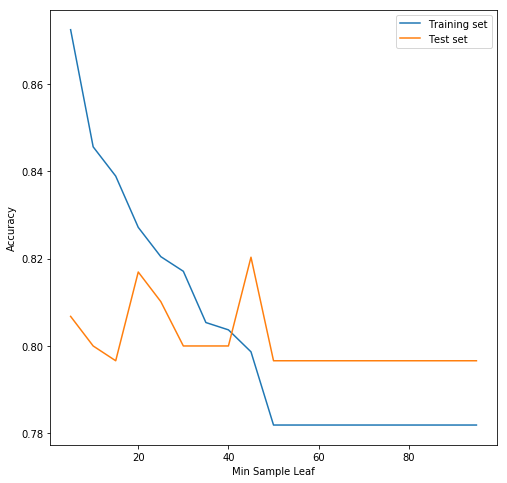

In [16]:
test_score = []
train_score = []
min_sample_leaf = np.arange(5,100,5)
for leaf in min_sample_leaf:
    clf = DecisionTreeClassifier(min_samples_leaf = leaf)
    clf.fit(X_train,y_train)
    train_score.append(clf.score(X_train,y_train))
    test_score.append(clf.score(X_test,y_test))

plt.figure(figsize = (8,8))
plt.plot(min_sample_split,train_score)
plt.plot(min_sample_split, test_score)
plt.xlabel('Min Sample Leaf')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

**Visualize a tree with min_samples_leaf = 5 and 100.**

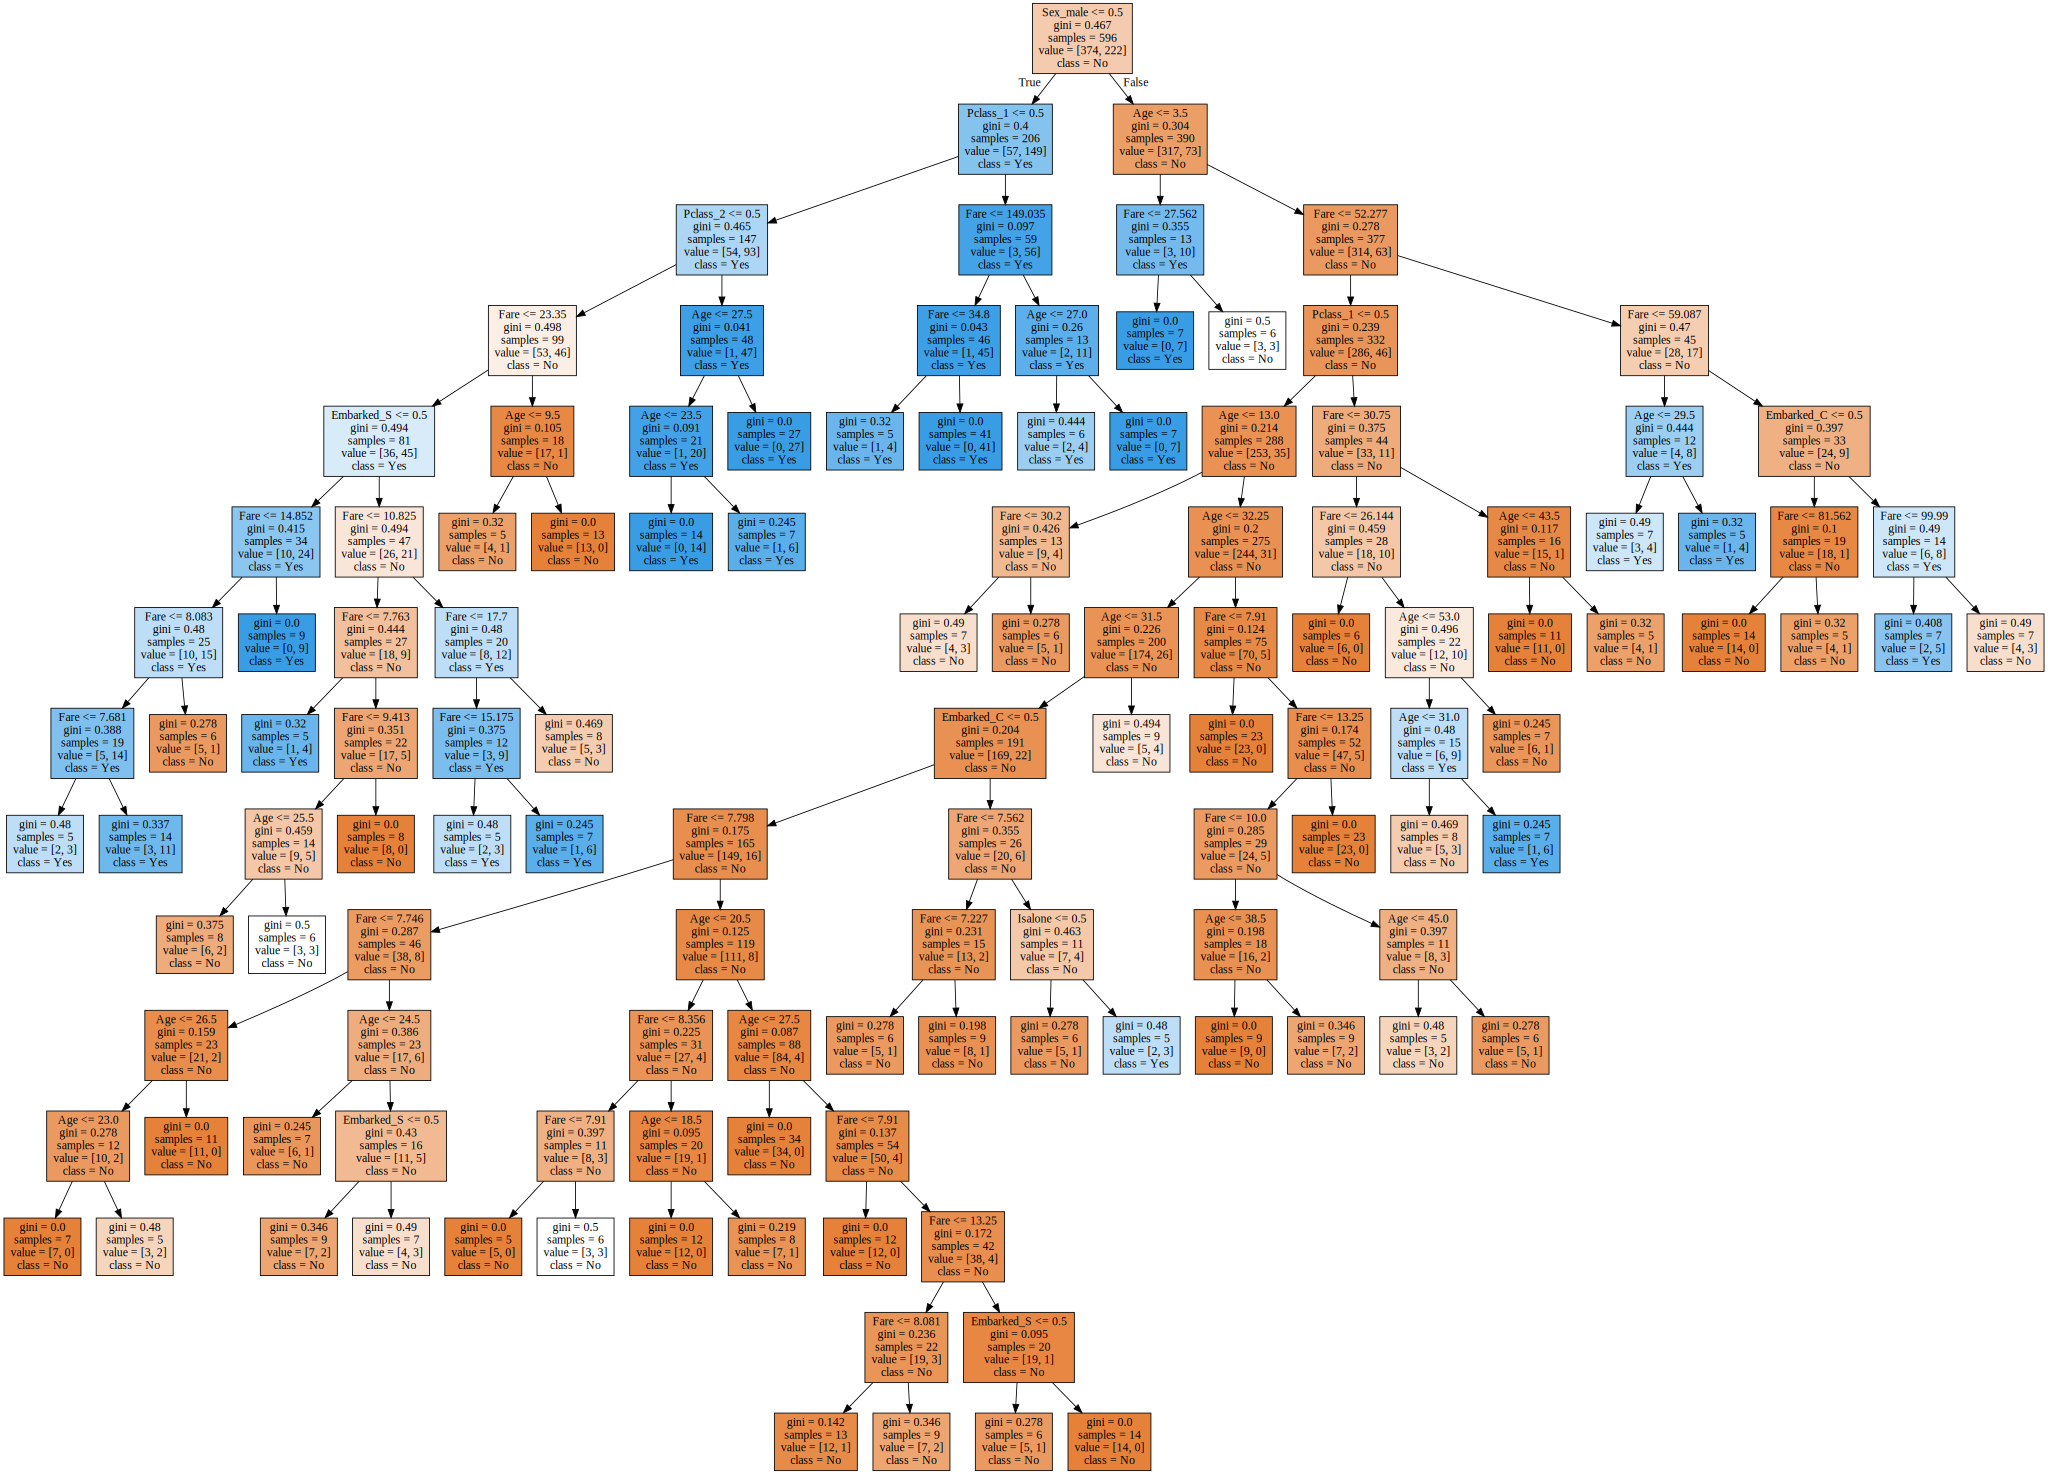

In [17]:
clf = DecisionTreeClassifier(min_samples_leaf = 5)
clf.fit(X_train,y_train)

dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 


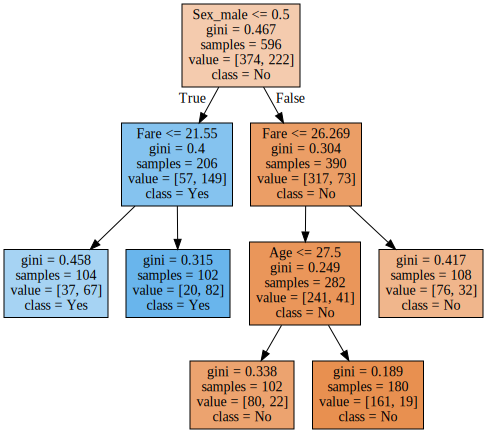

In [18]:
clf = DecisionTreeClassifier(min_samples_leaf = 100)
clf.fit(X_train,y_train)

dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 


## 8- Max leaf nodes

1. **max_leaf_nodes = too small:** Underfitting by limitting number of leaf nodes
1. **max_leaf_nodes = too large:** Overfitting by letting tree to have lots of leaf nodes

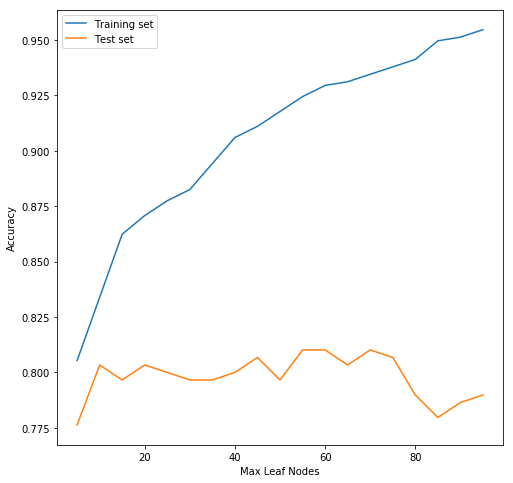

In [19]:
test_score = []
train_score = []
max_leaf_nodes  = np.arange(5,100,5)
for leaf in max_leaf_nodes :
    clf = DecisionTreeClassifier(max_leaf_nodes  = leaf)
    clf.fit(X_train,y_train)
    train_score.append(clf.score(X_train,y_train))
    test_score.append(clf.score(X_test,y_test))
    
plt.figure(figsize = (8,8))
plt.plot(min_sample_split,train_score)
plt.plot(min_sample_split, test_score)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(['Training set','Test set'])

**Visualize a tree with max_leaf_nodes = 3 and 100.**

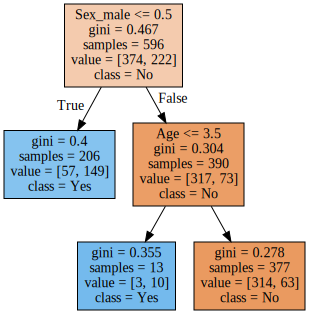

In [20]:
clf = DecisionTreeClassifier(max_leaf_nodes = 3)
clf.fit(X_train,y_train)

dot_data = tree.export_graphviz(clf,  
                     feature_names=X_test.columns.values,  
                     class_names=['No', 'Yes'], 
                     filled=True)  

graph = graphviz.Source(dot_data)  
graph 


Ref: [Playing with the knobs of sklearn decision tree](https://www.kaggle.com/drgilermo/playing-with-the-knobs-of-sklearn-decision-tree)